In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_excel("Online_Retail.xlsx")

In [3]:
print("Preview of dataset:")
print(df.head(), "\n")

# Summary statistics
print("Summary Statistics:")
print(df.describe().T, "\n")

# Check null values
print("Null Values per Column:")
print(df.isnull().sum(), "\n")

Preview of dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

Summary Statistics:
               count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.0

### Data Cleaning

In [4]:
# Remove missing values
df = df.dropna(subset=["CustomerID"])
df = df.dropna(subset=["Description"])

In [5]:
# Remove cancellations (negative quantities)
df = df[df["Quantity"] > 0]

In [6]:
# Calculate total sales per transaction
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [7]:
# Define Snapshot Date

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
print("Snapshot Date set to", snapshot_date, "\n")

Snapshot Date set to 2011-12-10 12:50:00 



###  RFM Metrics

In [8]:
# Compute RFM Metrics
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
}).reset_index()

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)
print("RFM Table Created")
print(rfm.head(), "\n")

RFM Table Created
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40 



In [13]:
# Assign RFM Scores
# 1 = lowest, 5 = highest
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

# Create RFM Segment & Score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)

print("RFM Scores Assigned")
print(rfm[["CustomerID","Recency","Frequency","Monetary","RFM_Segment","RFM_Score"]].head(10).to_string(index=False, justify="center", col_space=12, float_format="%.2f"))


RFM Scores Assigned
 CustomerID     Recency     Frequency    Monetary   RFM_Segment    RFM_Score 
  12346.00       326           1         77183.60       115            7     
  12347.00         2           7          4310.00       555           15     
  12348.00        75           4          1797.24       244           10     
  12349.00        19           1          1757.55       414            9     
  12350.00       310           1           334.40       112            4     
  12352.00        36           8          2506.04       355           13     
  12353.00       204           1            89.00       111            3     
  12354.00       232           1          1079.40       114            6     
  12355.00       214           1           459.40       112            4     
  12356.00        23           3          2811.43       435           12     


### Customer Segmentation

In [10]:
# Define Customer Groups
def rfm_level(row):
    if row["RFM_Score"] >= 12:
        return "Champions"
    elif row["RFM_Score"] >= 9:
        return "Loyal Customers"
    elif row["RFM_Score"] >= 6:
        return "Potential Loyalists"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(rfm_level, axis=1)

print("Customers Segmented")
print(rfm["Segment"].value_counts(), "\n")

Customers Segmented
Champions              1256
Potential Loyalists    1178
Loyal Customers        1022
At Risk                 883
Name: Segment, dtype: int64 



### Visualization


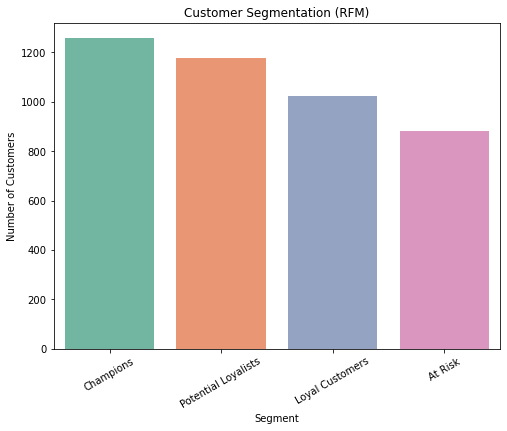

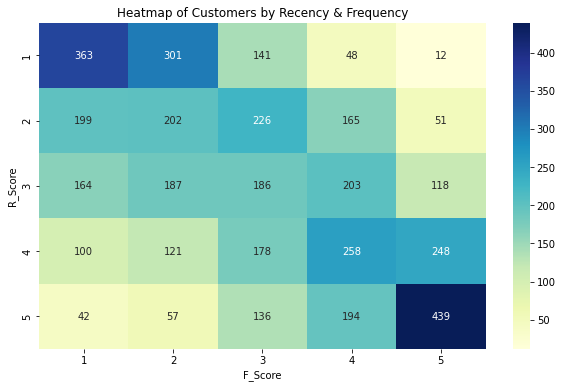

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="Set2")
plt.title("Customer Segmentation (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()

# Heatmap for RFM Scores
rfm_heatmap = rfm.groupby(["R_Score","F_Score"]).size().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(rfm_heatmap, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap of Customers by Recency & Frequency")
plt.show()



### Marketing Ideas


In [12]:
marketing_strategies = {
    "Champions": "Reward with loyalty programs, exclusive discounts, early access to new products.",
    "Loyal Customers": "Upsell and cross-sell with personalized offers, build community engagement.",
    "Potential Loyalists": "Offer discounts and incentives to convert them into loyal buyers.",
    "At Risk": "Send win-back campaigns, reminders, and special discounts to re-engage."
}

# Display results
print("Customer Segments:\n", rfm["Segment"].value_counts())
print("\nMarketing Strategies:")
for segment, strategy in marketing_strategies.items():
    print(f"{segment}: {strategy}")


Customer Segments:
 Champions              1256
Potential Loyalists    1178
Loyal Customers        1022
At Risk                 883
Name: Segment, dtype: int64

Marketing Strategies:
Champions: Reward with loyalty programs, exclusive discounts, early access to new products.
Loyal Customers: Upsell and cross-sell with personalized offers, build community engagement.
Potential Loyalists: Offer discounts and incentives to convert them into loyal buyers.
At Risk: Send win-back campaigns, reminders, and special discounts to re-engage.
